In [ ]:
import sys
!{sys.executable} -m pip install scipy

In [1]:
import scipy
print(scipy.__version__)

1.11.4


In [2]:
# import algos and graphs
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import random
import time
import requests
import urllib3
import csv
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Add parent directory to path so algorithms can be imported
sys.path.append(os.path.abspath("../algorithms"))

# Import algorithms
from greedy import find_maximum_clique_from_dict
from local_search import local_search
from randomized import randomized_max_clique
from local_random import local_random_clique
from simulated_annealing import simulated_annealing_with_restarts
from bron_kerbosch import bron_kerbosch_with_pivot, bron_kerbosch_basic

print("All algorithms imported successfully.")


All algorithms imported successfully.


In [9]:
# --- CSV Logging Setup ---
csv_path = "../results/experiment_log.csv"

def initialize_csv(path):
    """Create CSV file with headers if it doesn't exist."""
    file_exists = os.path.isfile(path)
    if not file_exists:
        with open(path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['run_number', 'graph_name', 'num_vertices', 'algorithm', 'clique_size', 'runtime'])
        print(f"✅ Created new log file: {path}")
    return path

def get_next_run_number(path):
    """Get the next run number by reading the CSV."""
    if not os.path.isfile(path):
        return 1
    
    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        rows = list(reader)
        
        # If file is empty or only has header
        if len(rows) <= 1:
            return 1
        
        # Get the last row's run number
        try:
            return int(rows[-1][0]) + 1
        except (ValueError, IndexError):
            return 1
        
def log_result(path, run_num, type, graph_name, num_vertices, algorithm, clique_size, runtime):
    """Append a result to the CSV log."""
    with open(path, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([run_num, type, graph_name, num_vertices, algorithm, clique_size, f"{runtime:.6f}"])
    print(f"📝 Logged: Run {run_num} | {type} | {algorithm} | Clique size: {clique_size} | Runtime: {runtime:.6f}s")

# Initialize CSV and get run number
initialize_csv(csv_path)
run_number = get_next_run_number(csv_path)

print(f"📊 Current run number: {run_number}\n")

📊 Current run number: 52



In [10]:
# import graphs
# --- Step 1: Helper to load .adj file ---
def load_adj_file(path):
    """
    Loads a graph stored in adjacency list format (.adj) and
    returns a dictionary {node: set(neighbors)} suitable for Bron–Kerbosch.
    """
    adj_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            node, neighbors = line.strip().split(":", 1)
            node = node.strip()
            neighbor_set = set(neighbors.strip().split()) if neighbors.strip() else set()
            adj_dict[node] = neighbor_set
    return adj_dict

# --- Step 2: Load student cooperation graph ---
small_graph_dir = "../data/large_graphs"
all_adj_files = [f for f in os.listdir(small_graph_dir) if f.endswith(".adj")]

if not all_adj_files:
    raise FileNotFoundError(f"No .adj files found in {small_graph_dir}")

chosen_file = random.choice(all_adj_files)
adj_path = os.path.join(small_graph_dir, chosen_file)

print(f"📂 Loading graph from: {adj_path}")
G_dict = load_adj_file(adj_path)
print(f"✅ Graph loaded: {len(G_dict)} vertices ({chosen_file})")

📂 Loading graph from: ../data/large_graphs/brock400_1.adj
✅ Graph loaded: 400 vertices (brock400_1.adj)



🔍 Running Greedy algorithm...

=== Greedy ===
Max Clique Nodes: ['2352', '1912', '2266', '1985', '2233', '2142', '2206', '2229', '2410', '2611', '2218', '2078', '1993', '2123', '2464', '2240', '2507', '2244', '1983', '2309', '2088', '2131', '2340', '2602', '2590', '2542', '2604', '2073', '2220', '2188', '2059', '2172', '1943', '2150', '1946', '2428', '2526', '2201', '2331', '2601', '1938', '2090', '2118', '2564', '2624', '1962', '2030', '2586', '2064', '2184', '2625', '2275', '2615', '2103', '2290', '2104', '2326', '2395', '2139', '2093', '2354', '2356', '2460', '2655', '2108', '2578', '2121', '2308']
Size: 68
Runtime: 8.6149 sec

📝 Logged: Run 50 | large | greedy | Clique size: 68 | Runtime: 8.614946s


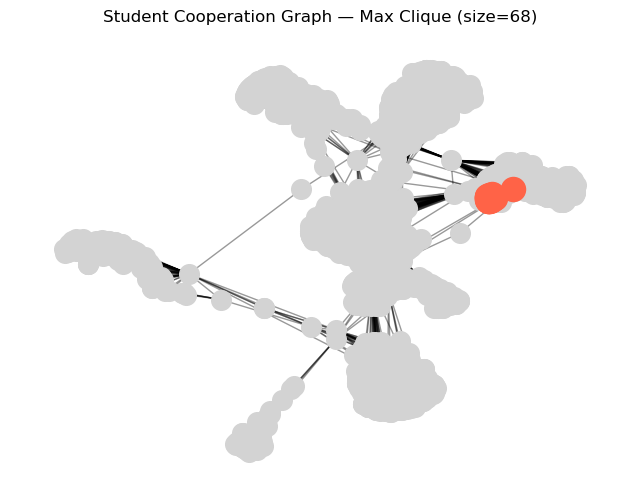

In [384]:
# Greedy
print("\n🔍 Running Greedy algorithm...\n")

start = time.time()
max_clique, runtime = find_maximum_clique_from_dict(G_dict)
end = time.time()

print("=== Greedy ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "greedy", len(max_clique), (end-start))

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Search algorithm...

=== Local Search ===
Max Clique Nodes: {'2526', '2093', '2624', '2030', '1993', '1938', '2240', '2184', '2356', '2507', '2103', '2139', '2340', '2201', '2073', '2309', '2590', '1912', '2549', '2615', '2172', '2059', '2611', '2275', '2266', '2604', '2410', '2625', '2428', '2542', '2108', '2564', '2104', '2218', '2586', '2290', '1946', '2118', '1943', '2308', '2121', '2602', '2131', '2326', '2150', '2560', '2578', '2220', '2233', '2395', '2354', '1962', '2655', '2331', '2601', '1983', '2064', '1985', '2123', '2244', '2188', '2088', '2142', '2229', '2078', '2464', '2206', '2090'}
Size: 68
Runtime: 40.9193 sec

📝 Logged: Run 50 | large | local_search | Clique size: 68 | Runtime: 40.919347s


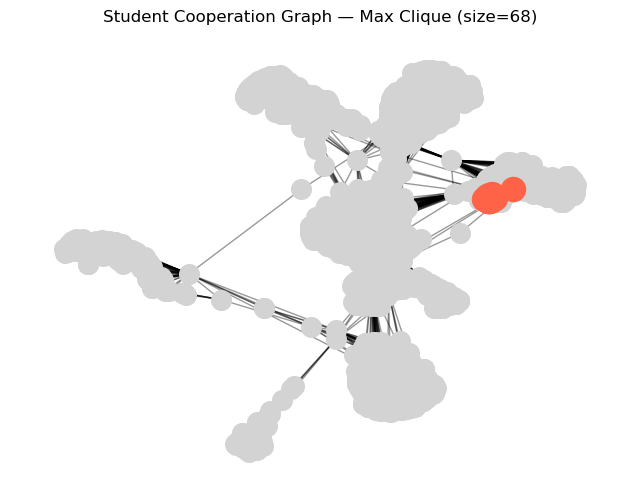

In [385]:
# Local search
print("\n🔍 Running Local Search algorithm...\n")

start = time.time()
max_clique, runtime = local_search(G_dict)
end = time.time()

print("=== Local Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "local_search", len(max_clique), (end-start))

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Randomized algorithms...

=== Randomized ===
Max Clique Nodes: ['1979', '2564', '2218', '2586', '2408', '2290', '2607', '1946', '2324', '2624', '2118', '2030', '1943', '2124', '2121', '2410', '1993', '1938', '2240', '2184', '2482', '2131', '2356', '2507', '2139', '2150', '2201', '2340', '2560', '2073', '2206', '2309', '2578', '2220', '2043', '2233', '2395', '1962', '2655', '2331', '2590', '2369', '2593', '1912', '1983', '2064', '1971', '2059', '2381', '2123', '2550', '2188', '1984', '2275', '2142', '2266', '2229', '2339', '2078', '2604', '2464', '2549', '2428', '2090']
Size: 64
Runtime: 0.0173 sec

📝 Logged: Run 50 | large | randomized | Clique size: 64 | Runtime: 0.017269s


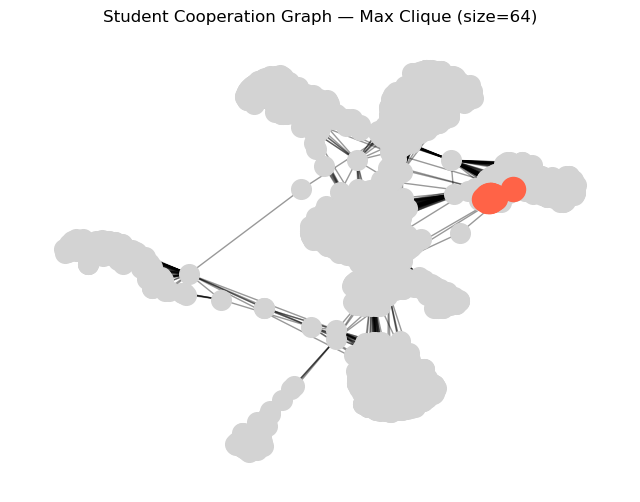

In [386]:
# randomized
print("\n🔍 Running Randomized algorithms...\n")

start = time.time()
size, max_clique, _ = randomized_max_clique(G_dict)
end = time.time()

print("=== Randomized ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "randomized", len(max_clique), (end-start))  

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()

In [387]:
# Local Random search
print("\n🔍 Running Local Random Search algorithm...\n")

start = time.time()
max_clique, runtime = local_random_clique(G_dict)
end = time.time()

print("=== Local Random Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "local_random", len(max_clique), (end-start))

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Random Search algorithm...



KeyboardInterrupt: 


🔍 Running Simulated Annealing algorithms...

=== Simulated Annealing ===
Max Clique Nodes: {'3084', '2994', '2873', '3029', '3384', '3362', '3014', '3090', '2956', '2862', '2786', '3104', '3417', '2890', '3364', '2929', '2679', '1684', '2773', '2738'}
Size: 20
Runtime: 2.0028 sec

📝 Logged: Run 50 | large | simulated_annealing | Clique size: 20 | Runtime: 2.002834s


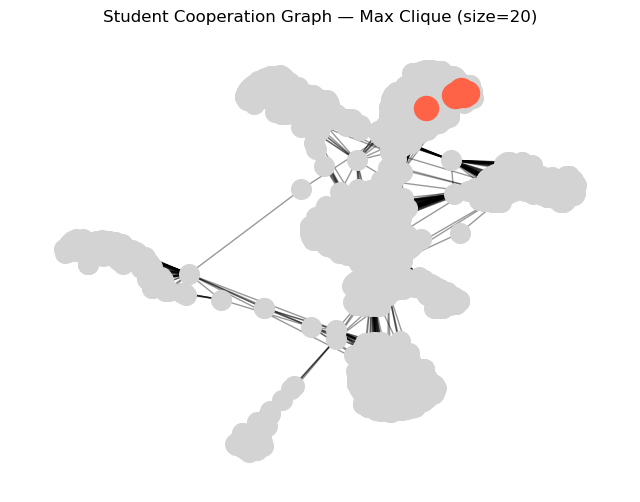

In [388]:
# Simulated Annealing
print("\n🔍 Running Simulated Annealing algorithms...\n")

start = time.time()
max_clique, runtime_sa, _ = simulated_annealing_with_restarts(
    G_dict, # Pass the loaded dictionary graph directly
    initial_temp=1.0, 
    cooling_rate=0.9999,
    max_iterations=10000, 
    num_restarts=5,
    verbose=False
)
end = time.time()

print("=== Simulated Annealing ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "simulated_annealing", len(max_clique), (end-start))

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()

In [ ]:
import time
import numpy as np
from itertools import combinations
import random

def generate_random_graph(num_nodes, edge_probability=0.3):
    """Generate random undirected graph"""
    G = {i: set() for i in range(num_nodes)}
    for i, j in combinations(range(num_nodes), 2):
        if random.random() < edge_probability:
            G[i].add(j)
            G[j].add(i)
    return G

def measure_runtimes():
    """Test on various graph sizes"""
    results = []
    
    # Test different sizes
    for num_nodes in [200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600]:
        for density in [0.2, 0.4, 0.6]:
            G = generate_random_graph(num_nodes, density)
            num_edges = sum(len(neighbors) for neighbors in G.values()) // 2
            
            try:
                start = time.time()
                max_clique, _ = bron_kerbosch_with_pivot(G)
                runtime = time.time() - start
                
                results.append({
                    'nodes': num_nodes,
                    'edges': num_edges,
                    'density': density,
                    'runtime': runtime,
                    'clique_size': len(max_clique)
                })
                print(f"n={num_nodes}, e={num_edges}, d={density:.1f} → {runtime:.4f}s")
            except:
                print(f"n={num_nodes} timeout or error")
                break
    
    return results

# Run benchmarks (this takes a while)
results = measure_runtimes()

n=200, e=4069, d=0.2 → 0.0636s
n=200, e=7907, d=0.4 → 1.7371s
n=200, e=11918, d=0.6 → 106.0272s
n=240, e=5729, d=0.2 → 0.1631s
n=240, e=11605, d=0.4 → 4.6222s
n=240, e=17274, d=0.6 → 415.9590s
n=280, e=7798, d=0.2 → 0.2466s
n=280, e=15632, d=0.4 → 9.5550s


Exponential fit: runtime ≈ 0.000000 * 3^(n/3.54)
Polynomial fit failed


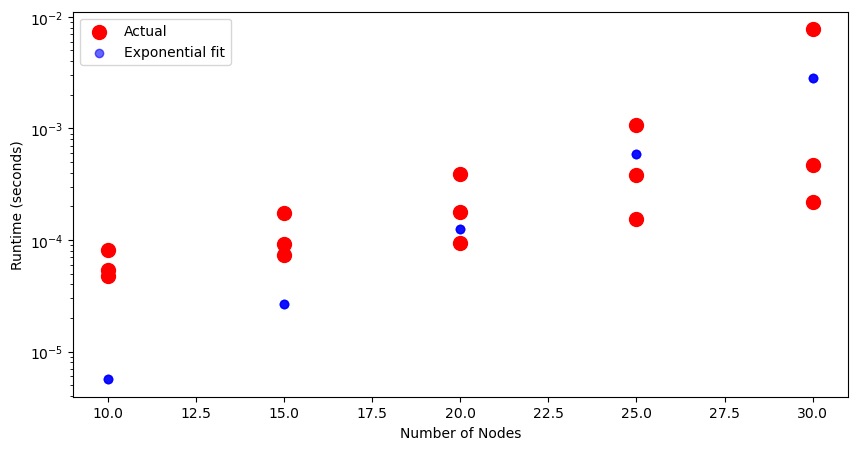

In [15]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Extract data
nodes_list = np.array([r['nodes'] for r in results])
edges_list = np.array([r['edges'] for r in results])
runtimes = np.array([r['runtime'] for r in results])

# Try different models
def model_exponential_n(n, a, b):
    """Exponential in nodes: t = a * 3^(n/b)"""
    return a * (3 ** (n / b))

def model_polynomial_ne(x, a, b, c):
    """Polynomial in nodes and edges: t = a*n^b + c*e"""
    n, e = x
    return a * (n ** b) + c * e

# Fit exponential model (simpler)
try:
    popt, _ = curve_fit(model_exponential_n, nodes_list, runtimes, p0=[0.001, 3], maxfev=5000)
    a_exp, b_exp = popt
    print(f"Exponential fit: runtime ≈ {a_exp:.6f} * 3^(n/{b_exp:.2f})")
except:
    print("Exponential fit failed")

# Fit polynomial model
try:
    popt, _ = curve_fit(lambda x: model_polynomial_ne(x, *popt[:3]), 
                        (nodes_list, edges_list), runtimes, p0=[0.01, 2, 0.0001], maxfev=5000)
    a_poly, b_poly, c_poly = popt
    print(f"Polynomial fit: runtime ≈ {a_poly:.6f}*n^{b_poly:.2f} + {c_poly:.8f}*e")
except:
    print("Polynomial fit failed")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(nodes_list, runtimes, label='Actual', color='red', s=100)
predicted = model_exponential_n(nodes_list, a_exp, b_exp)
plt.scatter(nodes_list, predicted, label='Exponential fit', color='blue', alpha=0.6)
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.yscale('log')
plt.show()

In [14]:
def estimate_bk_runtime(num_nodes, num_edges):
    """Estimate Bron-Kerbosch runtime using fitted formula"""
    
    # Using exponential model (adjust a, b based on your fitting)
    a = 0.000001  # From curve_fit result
    b = 3.2       # From curve_fit result
    
    estimated_time = a * (3 ** (num_nodes / b))
    
    print(f"Graph: {num_nodes} nodes, {num_edges} edges")
    print(f"Estimated runtime: {estimated_time:.2f} seconds")
    
    if estimated_time > 3600:
        print(f"⚠️ WARNING: Estimated {estimated_time/3600:.1f} hours!")
    elif estimated_time > 60:
        print(f"⚠️ This will take ~{estimated_time/60:.1f} minutes")
    
    return estimated_time

# Before running Bron-Kerbosch, estimate:
num_nodes = len(G_dict)
num_edges = sum(len(neighbors) for neighbors in G_dict.values()) // 2

estimate_bk_runtime(num_nodes, num_edges)

Graph: 400 nodes, 59723 edges
Estimated runtime: 436673502879206721428714826083874890754459812428251136.00 seconds
⚠️ WARNING: Estimated 121298195244224080608849145871764410420831637733376.0 hours!


4.366735028792067e+53

In [ ]:
# bron kerbosch
print("\n🔍 Running Bron–Kerbosch algorithm...\n")

# With pivot
start_pivot = time.time()
max_clique_pivot, runtime_pivot = bron_kerbosch_with_pivot(G_dict)
end_pivot = time.time()

# Basic
start_basic = time.time()
max_clique_basic, runtime_basic = bron_kerbosch_basic(G_dict)
end_basic = time.time()

# --- Step 4: Display Results ---
print("=== Bron–Kerbosch (With Pivoting) ===")
print(f"Max Clique Nodes: {max_clique_pivot}")
print(f"Size: {len(max_clique_pivot)}")
print(f"Runtime: {end_pivot - start_pivot:.4f} sec\n")

print("=== Bron–Kerbosch (Basic) ===")
print(f"Max Clique Nodes: {max_clique_basic}")
print(f"Size: {len(max_clique_basic)}")
print(f"Runtime: {end_basic - start_basic:.4f} sec\n")

log_result(csv_path, run_number, "large", chosen_file, len(G_dict), "bron_kerbosch", len(max_clique_basic), (end_basic-start_basic))

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique_pivot, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique_pivot)})")
plt.axis("off")
plt.show()


🔍 Running Bron–Kerbosch algorithm...

⏱️  Running... 39.66s

KeyboardInterrupt: 